In [1]:
%run 'Setup.py'

8 different classes: Electronic, Experimental, Folk, Hip-Hop, Instrumental, International, Pop or Rock.
objective 1: construct a classifier which, based on the features of a song, predicts its genre
objective 2: estimate its generalisation error under the 0–1 loss.
Features are real-valued, correspond to summary statistics (mean, sd, skewness, kurtosis, median, min, max) of 
time series of various music features, such as the chromagram or the Mel-frequency cepstrum.
Feature description: 

Feature description: 
chroma_cens: Chroma Energy Normalized (CENS, 12 chroma) - 84 features
chroma_cqt: Constant-Q chromagram (12 chroma) - 84 features
chroma_stft: Chromagram (12 chroma) - 84 features
mfcc: Mel-frequency cepstrum (20 coefficients) - 140 features
rmse: Root-mean-square - 7 features
spectral_bandwidth: Spectral bandwidth - 7 features
spectral_centroid: Spectral centroid - 7 features
spectral_contrast: Spectral contrast (7 frequency bands) - 49 features
spectral_rolloff: Roll-off freque

In [2]:
# Prepare data

# From Toby
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_np.ravel())

# Split training data into training and temporary validation sets
X_train, X_temp, Y_train, Y_temp = train_test_split(x_train_np, y_train_encoded, test_size=0.4, random_state=42)

# Split the temporary validation set into validation and test sets
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [105]:
# Plot colors
rgb_values = sns.color_palette("husl", 20)
# Map label to RGB
cmap = dict(zip(np.arange(0,20), rgb_values))


In [58]:
seed = np.random.randint(500)

In [59]:
# Model evaluations

from sklearn.metrics import classification_report

def evaluate_multiclass_classifier(model, X_val = X_val, Y_val = Y_val):
    """
    Evaluate the performance of a scikit-learn multiclass classifier.

    Parameters:
    - y_true: array-like of shape (n_samples,)
        True labels.
    - y_pred: array-like of shape (n_samples,)
        Predicted labels.

    Returns:
    - report: str
        Classification report.
    """
    Y_pred = model.predict(X_val)
    print(f'Report for model {model.__class__.__name__}')
    report = classification_report(Y_val, Y_pred)
    print(report)

# From Toby
def evaluate_sklearn_model(model, X_train, Y_train, X_test, Y_test):
    performance = {}
    for phase, X, Y in [('train', X_train, Y_train), ('test', X_test, Y_test)]:
        predicted = model.predict(X)
        accuracy = np.mean(predicted == Y)
        performance[phase + '_accuracy'] = accuracy
        print(f'Accuracy of the {model.__class__.__name__} model on the {phase} set: {accuracy:.2f}')
    return performance

# Data structures/exploration

## Relationship between samples

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import leidenalg

# Perform PCA on x_train
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)

# Construct T-SNE
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train_pca)


In [4]:
X_train_pca

array([[ 1.14125171e+03,  2.18903554e+02, -4.65145569e+01, ...,
        -2.56878700e+01, -1.53608905e+01, -2.19656388e+01],
       [ 1.49316784e+02, -2.15492130e+03, -1.41071056e+03, ...,
         3.23420273e+01, -6.29654060e+00,  6.42503854e+00],
       [ 6.92188949e+02, -5.47002776e+02, -1.10237959e+03, ...,
         1.03502598e+01, -7.55746929e+00, -3.50877471e+00],
       ...,
       [-1.59424378e+03, -1.84888250e+03, -4.11252017e+02, ...,
        -2.72804167e+01, -6.08921105e+00,  9.87131845e-01],
       [ 2.32525028e+03,  1.36536215e+03, -6.37784733e+02, ...,
         2.57070512e+00,  8.60895025e-01,  4.71034924e+00],
       [-6.78957571e+02, -2.06933831e+02,  1.50558653e+02, ...,
        -2.07235727e+01,  3.97815968e+00, -9.52348087e+00]])

In [17]:
import igraph as ig

# helper function to make igraph
def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""

    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es["weight"] = weights
    except KeyError:
        pass
    if g.vcount() != adjacency.shape[0]:
        logg.warning(
            f"The constructed graph has only {g.vcount()} nodes. "
            "Your adjacency matrix contained redundant nodes."
        )
    return g

# Apply KNN with 100 neighbors
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=100)
knn.fit(X_train_pca)
distances, indices = knn.kneighbors(X_train_pca)

# Construct adjacency matrix from the nearest neighbor graph
import numpy as np
adjacency = np.zeros((len(X_train_pca), len(X_train_pca)))
for i, neighbors in enumerate(indices):
    adjacency[i, neighbors] = 1

# Run Leiden clustering
# Create the igraph object
g = ig.Graph.Adjacency(adjacency.tolist())

# Print the graph summary
print(g.summary())
leiden_labels = np.array(leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition).membership)

IGRAPH D--- 3600 360000 -- 


In [19]:
from sklearn.cluster import SpectralClustering

# Run Spectral clustering
spectral_labels = SpectralClustering(n_components = 30).fit_predict(X_train_pca)
spectral_labels

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 7], dtype=int32)

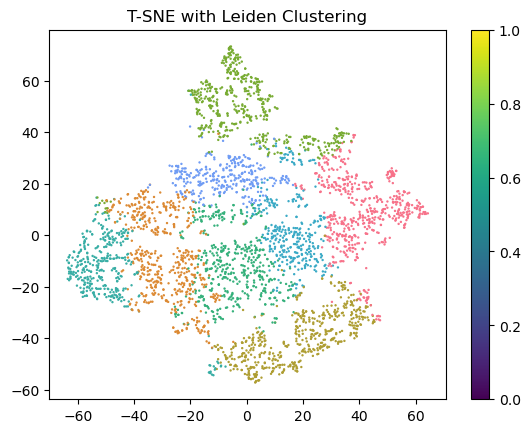

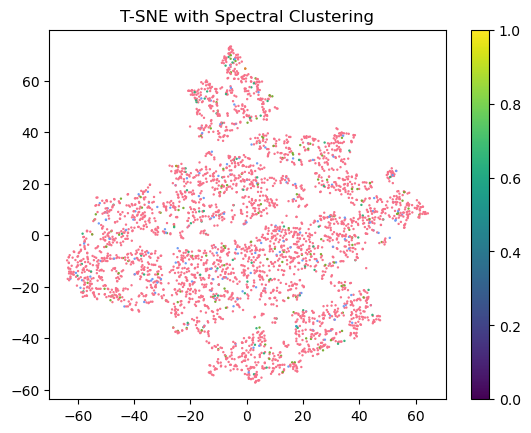

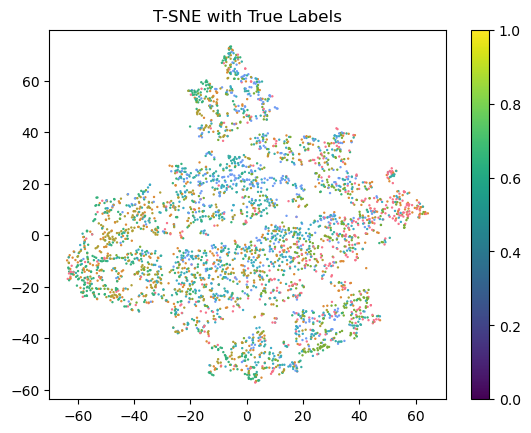

In [46]:
# Plot T-SNE with color labels of Leiden clustering
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=0.5, c=[cmap[x] for x in leiden_labels])
plt.title('T-SNE with Leiden Clustering')
plt.colorbar()
plt.show()

# Plot T-SNE with color labels of Spectral clustering
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=0.5, c=[cmap[x] for x in spectral_labels])
plt.title('T-SNE with Spectral Clustering')
plt.colorbar()
plt.show()

# Plot T-SNE with color labels of true labels
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=0.5, c=[cmap[x] for x in Y_train])
plt.title('T-SNE with True Labels')
plt.colorbar()
plt.show()

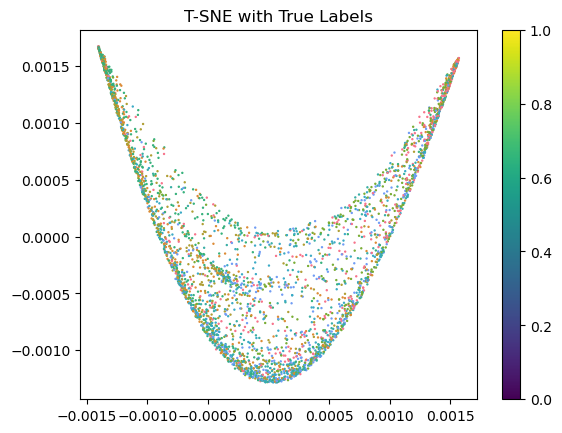

In [66]:
# See if spectral embedding look better than t-SNE
from sklearn.manifold import SpectralEmbedding
se = SpectralEmbedding(n_components=30).fit_transform(X_train.copy())

# Plot Spectral Embedding with color labels of True labels
plt.scatter(se[:, 0], se[:, 1], s=0.5, c=[cmap[x] for x in Y_train])
plt.title('T-SNE with True Labels')
plt.colorbar()
plt.show()

Scratch this also doesnt work well.

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)

df=pd.DataFrame(X_train_normalized)

# From towards data science
def de_correlate_df(df):
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values
        
    return X_aux

pca = PCA()
pca.fit(df)
original_variance = pca.explained_variance_ratio_

N_permutations = 100
variance = np.zeros((N_permutations, len(df.columns)))

for i in range(N_permutations):
    X_aux = de_correlate_df(df)
    
    pca.fit(X_aux)
    variance[i, :] = pca.explained_variance_ratio_

p_val = np.sum(variance > original_variance, axis=0) / N_permutations
print(f'Number of useful PCs: {len(p_val[p_val<0.05])}')

Number of useful PCs: 62


Also very useless.

## Data value and variance

In [101]:
# From Frenzi

data_summary = x_train.describe().T
data_summary

,count,mean,std,min,25%,50%,75%,max
chroma_cens_kurtosis_01,6000.0,0.107609,1.622556,-1.750532,-0.687784,-0.221944,0.422105,42.851593
chroma_cens_kurtosis_02,6000.0,0.012346,1.911876,-1.816620,-0.732581,-0.288179,0.336494,79.781960
chroma_cens_kurtosis_03,6000.0,0.127187,1.897625,-1.825738,-0.688573,-0.219804,0.427675,75.713921
chroma_cens_kurtosis_04,6000.0,-0.002926,1.241022,-1.760243,-0.700126,-0.262057,0.325397,23.989765
chroma_cens_kurtosis_05,6000.0,0.061176,1.659644,-1.781202,-0.728725,-0.271311,0.375869,43.405674
...,...,...,...,...,...,...,...,...
zcr_mean_01,6000.0,0.050551,0.028198,0.003490,0.032310,0.046176,0.062466,0.629665
zcr_median_01,6000.0,0.041315,0.027149,0.000000,0.024414,0.036621,0.051758,0.749512
zcr_min_01,6000.0,0.002485,0.004728,0.000000,0.000000,0.000977,0.003418,0.170898
zcr_skew_01,6000.0,3.551028,3.019898,-3.143864,1.648752,2.734890,4.623893,36.000904


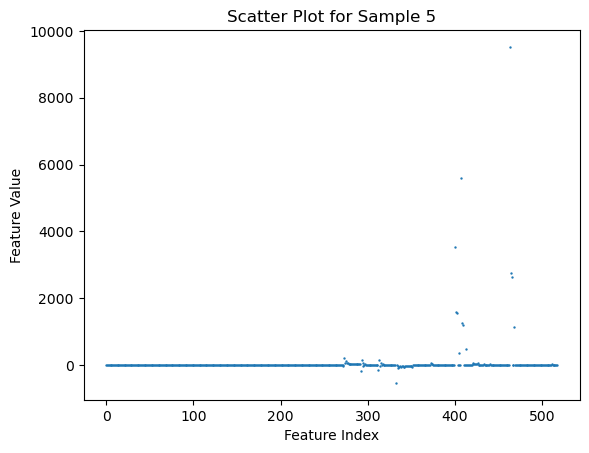

In [92]:
rand_idx = np.random.randint(0, num_samples = X_train.shape[0], size=10)

for i in rand_idx:
    plt.scatter(range(len(X_train[i])), X_train[i], s=0.5)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title(f'Scatter Plot for Sample {i}')
    plt.show()


We can see that there are some features with extremely different value ranges, hence I decided to normalize all X data going forward.

In [ ]:
import seaborn as sns

sns.barplot(data=pd.DataFrame(X_train))

In [99]:
# z-score all x values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val= scaler.fit_transform(X_val)
X_test= scaler.fit_transform(X_test)


In [113]:
# New data summary after z-scoring

new_data_summary = pd.DataFrame(X_train).describe().T
new_data_summary

,count,mean,std,min,25%,50%,75%,max
0,3600.0,-7.105427e-17,1.000139,-1.092436,-0.502559,-0.201376,0.191574,19.787682
1,3600.0,1.381611e-17,1.000139,-1.201042,-0.485655,-0.181670,0.233544,28.396530
2,3600.0,6.118562e-17,1.000139,-1.191979,-0.496105,-0.209967,0.197367,17.326441
3,3600.0,2.023073e-17,1.000139,-1.308565,-0.544052,-0.203492,0.254825,18.596846
4,3600.0,-9.868649e-18,1.000139,-1.228096,-0.520813,-0.215788,0.225478,19.239015
...,...,...,...,...,...,...,...,...
513,3600.0,2.316172e-15,1.000139,-1.587343,-0.647756,-0.148927,0.432080,20.580630
514,3600.0,-5.082354e-17,1.000139,-1.444733,-0.631852,-0.180251,0.397797,26.211292
515,3600.0,4.736952e-17,1.000139,-0.577727,-0.577727,-0.345215,0.236064,15.698084
516,3600.0,3.873445e-16,1.000139,-1.699736,-0.641881,-0.275834,0.355266,8.646634


<Axes: >

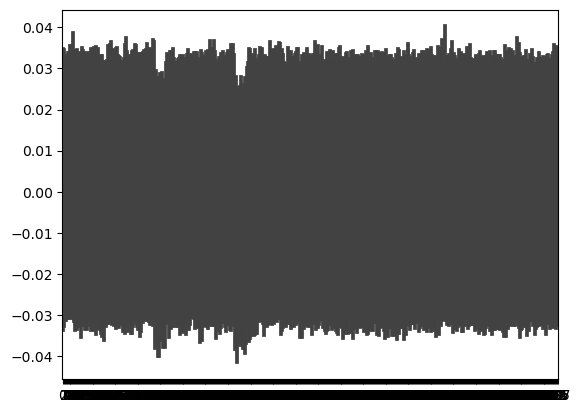

In [115]:
import seaborn as sns

sns.barplot(data=pd.DataFrame(X_train))


## Relationship between features

IGRAPH D--- 518 10360 -- 


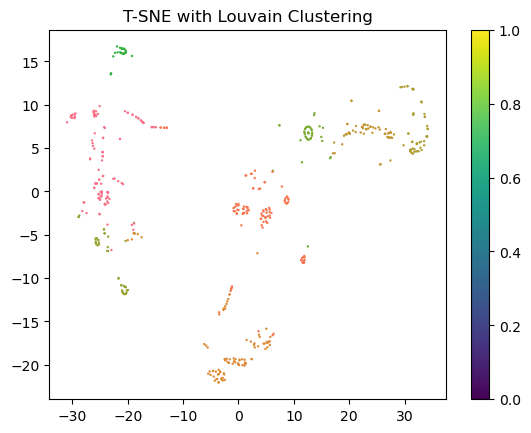

In [111]:
# Create a new matrix x_train_features
x_train_features = x_train.values.T

# Perform PCA on x_train_features
pca = PCA(n_components=30)
x_train_pca = pca.fit_transform(x_train_features)

# Construct T-SNE on the PCs
tsne = TSNE(n_components=2)
x_train_tsne = tsne.fit_transform(x_train_pca)

# Apply KNN with 20 neighbors but directly on the features x_train_features
# Trying smaller number of neighbors because there are only 518 features
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=20)
knn.fit(x_train_features)
distances, indices = knn.kneighbors(x_train_features)

# Construct adjacency matrix from the nearest neighbor graph
import numpy as np
adjacency = np.zeros((len(x_train_pca), len(x_train_pca)))
for i, neighbors in enumerate(indices):
    adjacency[i, neighbors] = 1

# Run Leiden clustering
# Create the igraph object
g = ig.Graph.Adjacency(adjacency.tolist())

# Print the graph summary
print(g.summary())

# Run Louvain clustering on x_train_features
g = get_igraph_from_adjacency(adjacency)
feature_leiden_labels = np.array(leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition).membership)

# Plot T-SNE colored by Louvain clustering labels
plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], s=0.5, c=[cmap[x] for x in feature_leiden_labels])
plt.title('T-SNE with Louvain Clustering')
plt.colorbar()
plt.show()


In [124]:
len(feature_leiden_labels)

518

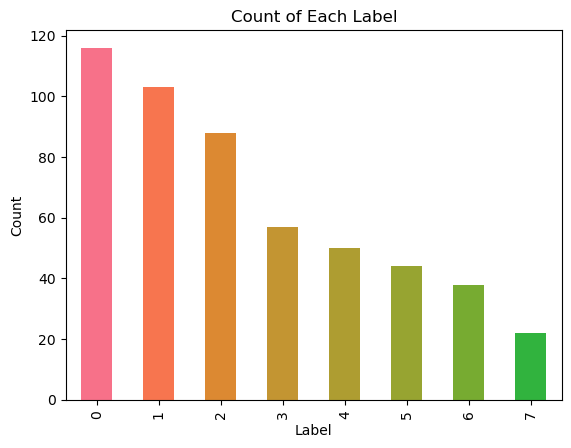

In [112]:
label_counts = pd.Series(feature_leiden_labels).value_counts()
label_counts.plot(kind='bar', color=[cmap[x] for x in label_counts.index])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.show()


It's kind of hard to see any structure between these groups of features, see what the feature looks like combining them.

In [136]:
# Create the leiden_clustered_df dataframe
leiden_clustered_df = pd.DataFrame(X_train, columns=feature_leiden_labels).T

# Group by the column name and take the average
leiden_clustered_df=leiden_clustered_df.groupby(leiden_clustered_df.index).mean().T
leiden_clustered_df


,0,1,2,3,4,5,6,7
0,-0.156956,-0.001014,-0.056850,-0.017368,0.111452,0.190078,-0.180121,-0.589567
1,-0.054519,0.159236,-0.039114,0.557486,0.653322,-0.409202,-0.113206,-0.631388
2,0.037466,0.323210,-0.098553,-0.375248,0.551884,-0.514542,0.230845,-0.026448
3,0.281399,0.412732,0.051543,-0.640251,0.098895,-0.324628,0.232588,0.311881
4,0.188904,-0.134039,0.053107,-0.309216,-0.434629,0.093735,0.104056,0.554639
...,...,...,...,...,...,...,...,...
3595,0.515309,-0.090351,-0.207004,-0.677448,-0.354697,0.153003,-0.016208,0.767573
3596,-0.055779,-0.413668,0.001064,0.535241,-0.064232,0.315171,0.084159,-0.658800
3597,0.285558,-0.417126,-0.133020,0.060944,-0.412693,-0.076102,-0.073982,0.075472
3598,-0.140891,0.350522,0.027016,0.041665,0.546036,-0.239478,-0.068794,-0.366474


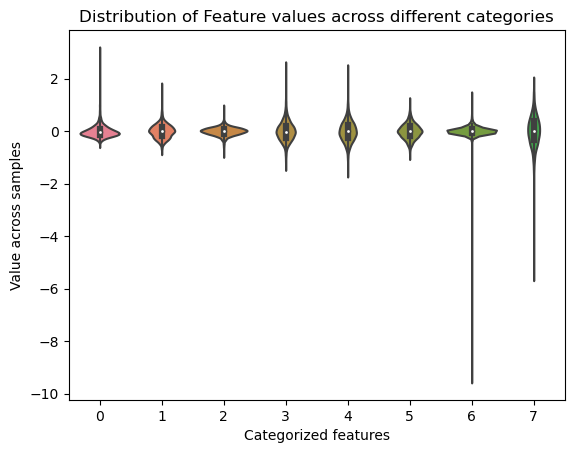

In [141]:

# Create the violin plot
sns.violinplot(data=leiden_clustered_df, palette=[cmap[x] for x in leiden_clustered_df.columns])
plt.xlabel('Categorized features')
plt.ylabel('Value across samples')
plt.title('Distribution of Feature values across different categories')
plt.show()


Here we can say that we've obtained semi-satisfactory clusters.

In [155]:
pd.DataFrame(X_train[:,feature_leiden_labels==6])



,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,-0.374021,-0.640386,-0.614252,-0.332704,-0.436092,-0.425324,-1.532193,-0.598069,-0.227139,-0.139251
1,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,1.193196,-0.394485,-0.246629,-1.801727,-0.584746,-0.533873,-1.105993,-0.389667,-0.401798,-0.339851
2,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,1.467210,-0.545457,-0.434977,-0.941980,0.805352,-0.309996,-0.830519,-0.490951,8.589720,-0.179883
3,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,-1.019243,0.736333,1.359249,1.853606,0.293998,1.868949,1.257336,0.819611,-0.298468,-0.278543
4,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,0.259233,0.074519,0.728248,4.514159,-0.552714,-0.538596,1.510392,0.231095,-0.238787,-0.255455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,-0.074105,0.336057,-0.205237,0.313606,-0.326617,-0.131076,0.056990,-0.115786,0.210654,-0.168231
3596,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,-0.340852,1.897027,1.570415,-1.047931,-0.775101,-0.228455,-0.716309,1.735969,-0.204502,-0.421602
3597,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,-0.207882,1.240851,1.195291,-0.603693,-0.641341,-0.424873,-0.285998,1.485263,-0.317911,-0.377831
3598,0.029786,0.04158,0.018307,0.041281,0.036563,0.039841,0.032343,0.040506,0.052122,0.032287,...,1.638955,-0.961914,-0.759235,-0.395482,1.057919,-0.498052,-0.050837,-0.920165,-0.230424,-0.061978


In [157]:
#Print the corresponding column names
print(x_train.loc[:,feature_leiden_labels==6].columns)

Index(['chroma_cqt_max_01', 'chroma_cqt_max_02', 'chroma_cqt_max_03',
       'chroma_cqt_max_04', 'chroma_cqt_max_05', 'chroma_cqt_max_06',
       'chroma_cqt_max_07', 'chroma_cqt_max_08', 'chroma_cqt_max_09',
       'chroma_cqt_max_10', 'chroma_cqt_max_11', 'chroma_cqt_max_12',
       'chroma_stft_max_01', 'chroma_stft_max_02', 'chroma_stft_max_03',
       'chroma_stft_max_04', 'chroma_stft_max_05', 'chroma_stft_max_06',
       'chroma_stft_max_07', 'chroma_stft_max_08', 'chroma_stft_max_09',
       'chroma_stft_max_10', 'chroma_stft_max_11', 'chroma_stft_max_12',
       'mfcc_kurtosis_03', 'mfcc_mean_05', 'mfcc_median_05',
       'rmse_kurtosis_01', 'rmse_std_01', 'spectral_bandwidth_skew_01',
       'spectral_centroid_skew_01', 'spectral_contrast_kurtosis_01',
       'spectral_contrast_kurtosis_06', 'spectral_contrast_kurtosis_07',
       'spectral_contrast_skew_01', 'spectral_rolloff_skew_01',
       'tonnetz_kurtosis_01', 'tonnetz_kurtosis_02'],
      dtype='object')


Normalization doesn't completely work for this group of features, should watch out.

# Splitting features for Ensemble models

This seems a bit crazy (but hey we're desperate at this point), but essentially I'll try fitting different modesl for different subsets of features and then do voting.

At this point, it seems reasonable to split features into groups and potentially do ensemble models or something hierarchical on them. I will try splitting by
1. Based on the names of the features (Max)
2. Based on correlation block structure/potentially hierarchical clustering on that
3. The vanilla Leiden clustering that I did above on PCAs

In [ ]:
# from Max
def split_features_by_type(X, feature_structure):
    """
    Splits the dataset into subsets based on the feature structure provided.

    :param X: numpy array, the dataset to be split (features only)
    :param feature_structure: dict, keys are feature names and values are the number of features of that type
    :return: dict of feature subsets
    """
    feature_subsets = {}
    start_idx = 0
    
    for feature_name, feature_count in feature_structure.items():
        end_idx = start_idx + feature_count
        feature_subsets[feature_name] = X[:, start_idx:end_idx]
        start_idx = end_idx
    
    return feature_subsets

# Define the structure of your features based on the information you've provided
feature_structure = {
    'chroma_cens': 84,
    'chroma_cqt': 84,
    'chroma_stft': 84,
    'mfcc': 140,
    'rmse': 7,
    'spectral_bandwidth': 7,
    'spectral_centroid': 7,
    'spectral_contrast': 49,
    'spectral_rolloff': 7,
    'tonnetz': 42,
    'zcr': 7
}

# Example usage with a hypothetical dataset X_train_scaled
# This would be your preprocessed and scaled training data as a NumPy array
feature_subsets = split_features_by_type(X_train_scaled, feature_structure)

# Now feature_subsets is a dictionary where, for example,
# feature_subsets['mfcc'] contains only the MFCC features of the dataset.

# Extending Frensi's thing to Ensemble models

In [98]:
X_val

array([[-1.96787745e-01,  1.69369745e+00,  1.05151379e+00, ...,
         1.02539062e-02,  9.93684113e-01,  4.53240350e-02],
       [-9.04854894e-01, -1.36752987e+00, -1.52290797e+00, ...,
         1.95312500e-03,  4.24163389e+00,  3.04311234e-02],
       [ 2.17046842e-01, -3.38434249e-01, -7.38796964e-02, ...,
         2.92968750e-03,  1.53798103e+00,  2.28877198e-02],
       ...,
       [-9.56903100e-01,  7.08491862e-01,  2.08194447e+00, ...,
         2.44140625e-03,  9.52752829e-01,  4.91775796e-02],
       [-1.23146462e+00, -1.36014566e-01, -7.79537261e-01, ...,
         0.00000000e+00,  5.33990812e+00,  2.45248843e-02],
       [-6.41145885e-01, -1.02457762e+00, -7.15180516e-01, ...,
         0.00000000e+00,  3.07745981e+00,  3.92973758e-02]])

Number of useful PCs: 62


# The below stuff is just me messing around - all kinda useless (<0.6)

# Multi-class LDA (+Bayesian) & QDA

In [89]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_vanilla = LinearDiscriminantAnalysis(solver = 'svd').fit(X_train, Y_train)
evaluate_multiclass_classifier(lda_vanilla)
evaluate_sklearn_model(lda_vanilla, X_train, Y_train, X_test, Y_test)

lda_lsqr = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto').fit(X_train, Y_train)
evaluate_multiclass_classifier(lda_lsqr)
evaluate_sklearn_model(lda_lsqr, X_train, Y_train, X_test, Y_test)

lda_eigen = LinearDiscriminantAnalysis(solver = 'eigen', shrinkage='auto').fit(X_train, Y_train)
evaluate_multiclass_classifier(lda_eigen)
evaluate_sklearn_model(lda_eigen, X_train, Y_train, X_test, Y_test)

Report for model LinearDiscriminantAnalysis
              precision    recall  f1-score   support

           0       0.54      0.55      0.55       157
           1       0.42      0.27      0.32       139
           2       0.63      0.58      0.60       156
           3       0.59      0.70      0.64       148
           4       0.57      0.51      0.54       141
           5       0.59      0.64      0.62       154
           6       0.38      0.45      0.41       153
           7       0.60      0.61      0.61       152

    accuracy                           0.54      1200
   macro avg       0.54      0.54      0.54      1200
weighted avg       0.54      0.54      0.54      1200

Accuracy of the LinearDiscriminantAnalysis model on the train set: 0.73
Accuracy of the LinearDiscriminantAnalysis model on the test set: 0.54
Report for model LinearDiscriminantAnalysis
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       157
         

{'train_accuracy': 0.6863888888888889, 'test_accuracy': 0.5658333333333333}

In [158]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis().fit(X_train, Y_train)
evaluate_multiclass_classifier(qda)
evaluate_sklearn_model(qda, X_train, Y_train, X_test, Y_test)

/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Report for model QuadraticDiscriminantAnalysis
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.12      0.91      0.21       139
           2       0.00      0.00      0.00       156
           3       0.11      0.07      0.08       148
           4       0.00      0.00      0.00       141
           5       0.00      0.00      0.00       154
           6       0.00      0.00      0.00       153
           7       0.09      0.01      0.01       152

    accuracy                           0.12      1200
   macro avg       0.04      0.12      0.04      1200
weighted avg       0.04      0.12      0.04      1200



/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Accuracy of the QuadraticDiscriminantAnalysis model on the train set: 1.00
Accuracy of the QuadraticDiscriminantAnalysis model on the test set: 0.15


{'train_accuracy': 1.0, 'test_accuracy': 0.15}

# GP

In [62]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Create the Gaussian Processes classifier
gp_vanilla = GaussianProcessClassifier(multi_class='one_vs_one', n_jobs = -1).fit(X_train, Y_train)

evaluate_multiclass_classifier(gp_vanilla)
evaluate_sklearn_model(gp_vanilla, X_train, Y_train, X_test, Y_test)


Report for model GaussianProcessClassifier
              precision    recall  f1-score   support

           0       0.13      1.00      0.23       157
           1       0.00      0.00      0.00       139
           2       0.00      0.00      0.00       156
           3       0.00      0.00      0.00       148
           4       1.00      0.01      0.03       141
           5       0.00      0.00      0.00       154
           6       1.00      0.01      0.01       153
           7       0.00      0.00      0.00       152

    accuracy                           0.13      1200
   macro avg       0.27      0.13      0.03      1200
weighted avg       0.26      0.13      0.04      1200



/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Accuracy of the GaussianProcessClassifier model on the train set: 1.00
Accuracy of the GaussianProcessClassifier model on the test set: 0.14


{'train_accuracy': 1.0, 'test_accuracy': 0.13916666666666666}

In [63]:
gp_vanilla = GaussianProcessClassifier(multi_class='one_vs_rest', n_jobs = -1).fit(X_train, Y_train)

evaluate_multiclass_classifier(gp_vanilla)
evaluate_sklearn_model(gp_vanilla, X_train, Y_train, X_test, Y_test)


Report for model GaussianProcessClassifier
              precision    recall  f1-score   support

           0       1.00      0.01      0.03       157
           1       0.00      0.00      0.00       139
           2       0.00      0.00      0.00       156
           3       0.00      0.00      0.00       148
           4       1.00      0.01      0.03       141
           5       0.00      0.00      0.00       154
           6       1.00      0.01      0.01       153
           7       0.13      1.00      0.23       152

    accuracy                           0.13      1200
   macro avg       0.39      0.13      0.04      1200
weighted avg       0.39      0.13      0.04      1200



/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliazhao/miniconda3/envs/sml-practical-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Accuracy of the GaussianProcessClassifier model on the train set: 1.00
Accuracy of the GaussianProcessClassifier model on the test set: 0.12


{'train_accuracy': 1.0, 'test_accuracy': 0.115}

Ok scratch all of this lol.

# Multi-class classifier

https://scikit-learn.org/stable/modules/multiclass.html#:~:text=For%20a%20multi%2Dlabel%20classification,were%20assigned%20a%20lower%20number.

### One vs Rest

In [ ]:
linearsvc

OneVsRestClassifier(estimator=LinearSVC(dual='auto', random_state=0))

In [86]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
linearsvc = OneVsRestClassifier(LinearSVC(dual="auto", random_state=0)).fit(X_train, Y_train)
evaluate_multiclass_classifier(linearsvc)
evaluate_sklearn_model(linearsvc, X_train, Y_train, X_test, Y_test)

Report for model OneVsRestClassifier
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       157
           1       0.38      0.30      0.34       139
           2       0.63      0.62      0.62       156
           3       0.57      0.66      0.61       148
           4       0.53      0.60      0.56       141
           5       0.55      0.56      0.55       154
           6       0.43      0.24      0.30       153
           7       0.58      0.70      0.63       152

    accuracy                           0.53      1200
   macro avg       0.52      0.53      0.52      1200
weighted avg       0.52      0.53      0.52      1200

Accuracy of the OneVsRestClassifier model on the train set: 0.67
Accuracy of the OneVsRestClassifier model on the test set: 0.53


{'train_accuracy': 0.6675, 'test_accuracy': 0.5341666666666667}

506


### One vs one

### Output code classifier

# Notes: Model optimization

https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
^ More efficient and less exhaustive than GridSearchCV